In [44]:
a = np.ones((2,2))
a
b = (np.arange(2) + 1)[(slice(None),) + (np.newaxis,) * 0]
b
a *= b
a
a[:, [1, 0]]

array([[1., 1.],
       [1., 1.]])

array([1, 2])

array([[1., 2.],
       [1., 2.]])

array([[2., 1.],
       [2., 1.]])

In [69]:
slice(None, 60 // 2, -1)

slice(None, 30, -1)

left (slice(None, 5, None),)
left_rev (slice(None, 5, -1),)
right (slice(5, None, None),)
fft_norm1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
fft_norm2 [1.00000000e+00 5.71141054e-03 1.06407812e-09 6.46681456e-21
 1.28201781e-36 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00]


ValueError: operands could not be broadcast together with shapes (6,) (5,) (6,) 

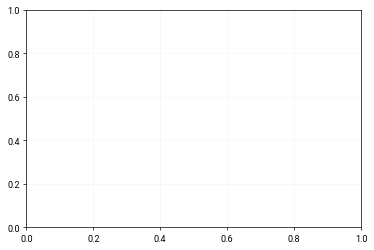

In [71]:
import numpy as np
import scipy.fftpack

from joshpyutil import mpl as plt


def gen_data(shape, alpha):
    profile_func = lambda x: np.exp(-x**2)
    # profile_func = lambda x: np.exp(-x**2)
    
    fft_phase = np.exp(2j * np.pi * np.random.uniform(size=shape))
    fft_norm = np.ones(shape)
    for axis, size in enumerate(shape):
        slices = (slice(None),) * axis
        newaxes = (np.newaxis,) * axis
        
        left = slices + (slice(None, size // 2),)
        left_rev = slices + (slice(None, size // 2, -1),)
        right = slices + (slice(size // 2, None),)
        print('left', left)
        print('left_rev', left_rev)
        print('right', right)
        
        arg = np.arange(size // 2) / size / alpha
        profile = profile_func(arg)[(slice(None),) + newaxes]
        print('fft_norm1', fft_norm)
        fft_norm[left] *= profile
        print('fft_norm2', fft_norm)
        fft_norm[right] *= profile[::-1]
        print('fft_norm3', fft_norm)
        fft_norm[slices + ([[0, size // 2, -1]],)] = 0.
        
        fft_phase[right] = np.conj(fft_phase[left_rev])
    
    fft = fft_norm * fft_phase
    print('fft_norm', fft_norm)
    print('fft_phase', fft_phase)
    print('fft', fft)
    
    data = scipy.fftpack.ifft(fft)
    np.testing.assert_allclose(np.imag(data), 0., atol=1e-6)
    
    return np.real(data) * 2. * np.pi

with plt.autoplot() as ap:
    ap.plot(gen_data((11,), 0.04))

In [ ]:
import numpy as np
import scipy.fftpack

from joshpyutil import mpl as plt


def gen_data(n, alpha):
    profile_func = lambda x: np.exp(-x)
    # profile_func = lambda x: np.exp(-x**2)
    
    fft_phase = np.exp(2j * np.pi * np.random.uniform(size=2 * n))
    fft_norm = np.empty(n)
    arg = np.arange(n // 2) / n / alpha
    fft_norm[:n // 2] = profile_func(arg)
    fft_norm[[0, n // 2]] = 0.
    
    fft = fft_norm * fft_phase
    fft[n // 2 + 1:] = np.conj(fft[1:n // 2])[::-1]
    
    data = scipy.fftpack.ifft(fft)
    np.testing.assert_allclose(np.imag(data), 0., atol=1e-6)
    
    return np.real(data)

with plt.autoplot() as ap:
    ap.plot(gen_data(100, 0.01))

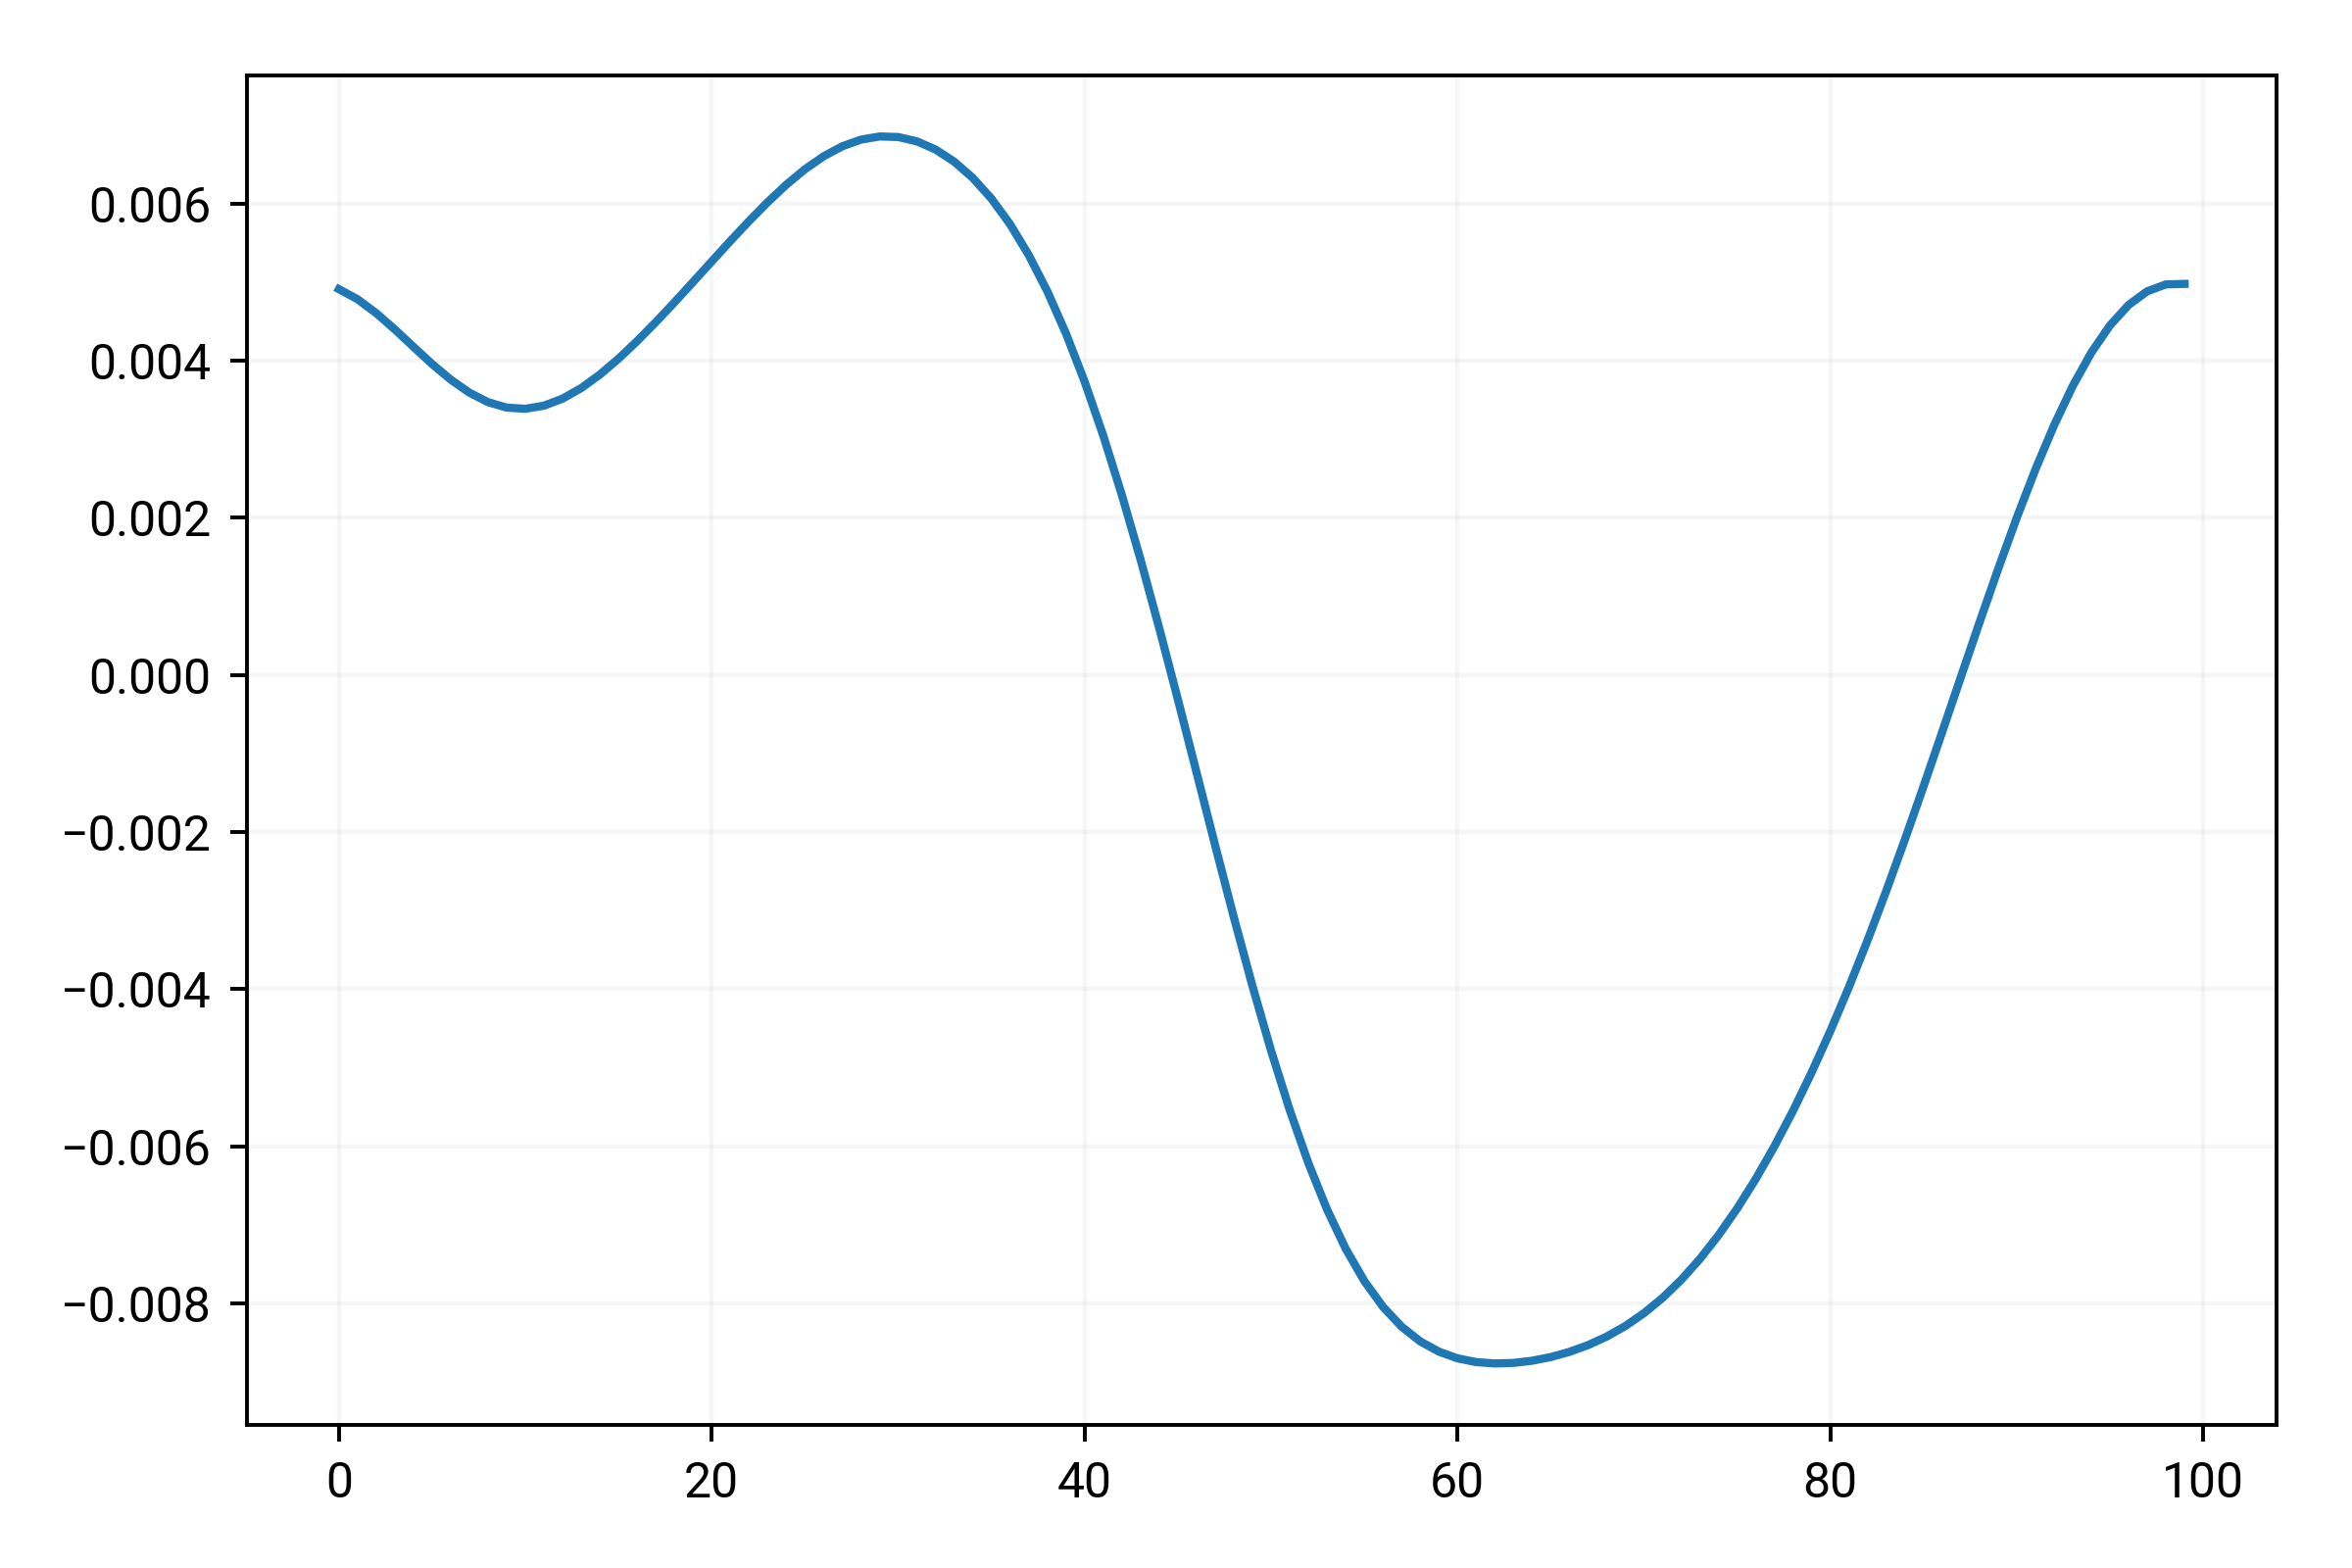

In [45]:
import numpy as np
import scipy.fftpack

from joshpyutil import mpl as plt


def gen_data(n, alpha):
    profile_func = lambda x: np.exp(-x)
    # profile_func = lambda x: np.exp(-x**2)
    
    fft_phase = np.exp(2j * np.pi * np.random.uniform(size=n))
    fft_norm = np.empty(n)
    arg = np.arange(n // 2) / n / alpha
    fft_norm[:n // 2] = profile_func(arg)
    fft_norm[[0, n // 2]] = 0.
    
    fft = fft_norm * fft_phase
    fft[n // 2 + 1:] = np.conj(fft[1:n // 2])[::-1]
    
    data = scipy.fftpack.ifft(fft)
    np.testing.assert_allclose(np.imag(data), 0., atol=1e-6)
    
    return np.real(data)

with plt.autoplot() as ap:
    ap.plot(gen_data(100, 0.01))

In [13]:
import numpy as np
import scipy.fftpack

from joshpyutil import mpl as plt

# np.random.seed(1)

X_LEN = 1.
# Y_LEN = 1.2

NUM_POINTS = 100

x = np.linspace(0, X_LEN, NUM_POINTS)
# y = np.linspace(0, Y_LEN, 2 * NUM_POINTS)

# xd, yd = np.meshgrid(x, y, indexing='ij', sparse=True)
# zd = np.sin(xd) + np.sin(2. + 7*yd) + np.sin(.5 + xd/2)
# Zd = scipy.fftpack.rfft(scipy.fftpack.rfft(zd, axis=0), axis=1)
# Zd
z = np.sin(13.6 * x + 1.2) + np.cos(23.6 * x - 1.2) + 0.05 * np.random.normal(size=x.shape)
z_fft = scipy.fftpack.fft(z)
z_fft_norm = np.abs(z_fft)
z_fft_phase = np.exp(1.j * np.angle(z_fft))
np.testing.assert_allclose(z_fft, z_fft_norm * z_fft_phase)

profile_func = lambda x: np.exp(-x)
# profile_func = lambda x: np.exp(-x**2)

def gen_data(n, alpha):
    profile_func = lambda x: np.exp(-x)
    # profile_func = lambda x: np.exp(-x**2)
    
    fft_phase = np.exp(2j * np.pi * np.random.uniform(size=n))
    fft_norm = np.empty(n)
    arg = np.arange(n // 2) / n / alpha
    fft_norm[:n // 2] = profile_func(arg)
    fft_norm[[0, n // 2]] = 0.
    
    fft = fft_norm * fft_phase
    fft[n // 2 + 1:] = np.conj(fft[1:n // 2])[::-1]
    
    data = scipy.fftpack.ifft(z_fft_mod)
    np.testing.assert_allclose(np.imag(data), 0., atol=1e-6)
    
    return np.real(data)
    
    

alpha = 0.01
z_fft_mod_norm = z_fft_norm.copy()
z_fft_mod_phase = z_fft_phase.copy()

z_fft_mod_phase = np.exp(2j * np.pi * np.random.uniform(size=n))
z_fft_mod_norm[:n // 2] = profile_func(np.arange(n // 2) / (alpha * n)) * 100 #* np.random.lognormal(size=n // 2, sigma=0.1)
z_fft_mod_norm[[0, n // 2]] = 0.

z_fft_mod = z_fft_mod_norm * z_fft_mod_phase
z_fft_mod[n // 2 + 1:] = np.conj(z_fft_mod[1:n // 2])[::-1]
z_mod = np.real(scipy.fftpack.ifft(z_fft_mod))

np.testing.assert_allclose(z_fft[1:n // 2], np.conj(z_fft[n // 2 + 1:][::-1]))

with plt.autoplot(2) as ap:
    ap.plot(x, z, label='$z$')
    ap.plot(x, gen_data(n, 1.), label='$z_\mathrm{mod}$')
    ap.legend()
    
    ap = ap.next()
    ap.plot(x, np.abs(z_fft))
    arg = np.angle(z_fft)
    arg[arg < 0] += 2 * np.pi
    _ = ap.ax.twinx().plot(x, arg, color=plt.COLORS[3])

NameError: name 'n' is not defined

In [134]:
gen_data(100, 0.01)

array([ 0.7529422 ,  0.80376783,  0.85222504,  0.89714776,  0.93713289,
        0.97063045,  0.99607205,  1.01201984,  1.01731317,  1.01119023,
        0.99336663,  0.96406137,  0.92396991,  0.87419254,  0.81613156,
        0.75137324,  0.68156949,  0.60833194,  0.53314667,  0.45731388,
        0.38191266,  0.30778788,  0.23555499,  0.16561831,  0.09819947,
        0.03337379, -0.02888796, -0.08867515, -0.14609509, -0.20123789,
       -0.2541537 , -0.30484557, -0.35327847, -0.39940203, -0.44318102,
       -0.48462568, -0.5238129 , -0.56089067, -0.59606072, -0.629539  ,
       -0.66149914, -0.69200867, -0.72097173, -0.74809156, -0.77286288,
       -0.79459739, -0.81247806, -0.8256318 , -0.83320788, -0.83445122,
       -0.82876368, -0.81575082, -0.79525405, -0.7673686 , -0.73244746,
       -0.69109175, -0.64412879, -0.59258123, -0.5376316 , -0.48058595,
       -0.42283803, -0.36583196, -0.31101863, -0.25980072, -0.2134639 ,
       -0.17309688, -0.13950945, -0.11316204, -0.09412128, -0.08

In [43]:
n, = z_fft.shape
z_fft[[0, n // 2]]
np.allclose(z_fft[1:n // 2], np.conj(z_fft[n // 2 + 1:][::-1]))

array([11.67294426+0.j,  0.31190883+0.j])

True

In [71]:
n, = z_fft.shape
z_fft[[0, n // 2]]
np.allclose(z_fft_mod[1:n // 2], np.conj(z_fft_mod[n // 2 + 1:][::-1]))

array([10.22289376+0.j,  1.02653616+0.j])

True

In [81]:
z_fft

array([ 10.22289376+0.00000000e+00j,  11.82089791+2.78544881e+00j,
        50.94240683+1.31015213e+01j,  -4.70908958+7.91266510e+00j,
       -15.21997125-4.69966575e+01j,  -2.71350804-1.00392677e+01j,
        -1.61024788-5.82440930e+00j,  -0.99501291-4.17900674e+00j,
        -0.26222937-3.29169897e+00j,   0.35354075-3.06672654e+00j,
         0.22968735-1.88656478e+00j,   0.28612246-2.55615786e+00j,
         0.27954349-1.28601328e+00j,   0.52537958-1.49306494e+00j,
         0.53789008-1.87280473e+00j,   0.52048451-1.62979071e+00j,
         0.43461234-1.10787866e+00j,   0.18296149-1.86258758e+00j,
         1.3135565 -1.28155094e+00j,   0.72109498-6.67628449e-01j,
         0.12035465-4.91141218e-01j,   1.2475132 -1.03217053e+00j,
         0.77111082-8.21012927e-01j,   0.77998753-4.80892172e-01j,
         0.4703367 -1.24487795e+00j,   0.32588092-5.13920370e-01j,
         0.66891735-6.13919600e-01j,   0.3442541 -2.75121249e-01j,
         1.03585325-4.74754849e-01j,   0.65666346-4.88785395e-